# MLOps first week Homework

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

import pickle

### Q1. Downloading the data

In [32]:
df = pd.read_parquet('data/fhv_tripdata_2021-01.parquet')

In [33]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


How many records are in the dataset?

In [34]:
df.shape[0]

1154112

There are 1154112 records in the dataset

### Q2. Computing Duration?

What is the average trip duration in January?

In [35]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df.duration.mean()

19.1672240937939

The average duration of trips in January is 19.16

#### Data preparation

c:\Mlapps\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


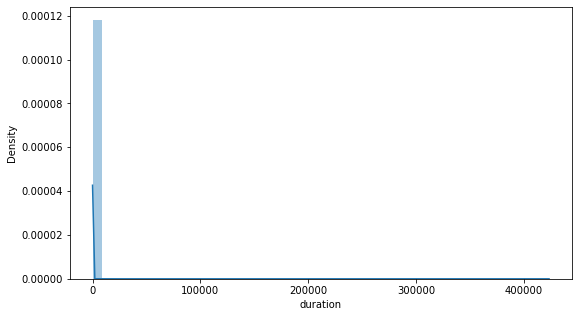

In [36]:
plt.figure(figsize=(9,5))
sns.distplot(df.duration)

plt.show()

In [37]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
50%      1.340000e+01
95%      4.725000e+01
98%      6.613333e+01
99%      9.030000e+01
max      4.233710e+05
Name: duration, dtype: float64

Selecting only the values between 1 and 60

In [38]:
new_df = df[(df.duration >= 1) & (df.duration <= 60)]

c:\Mlapps\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

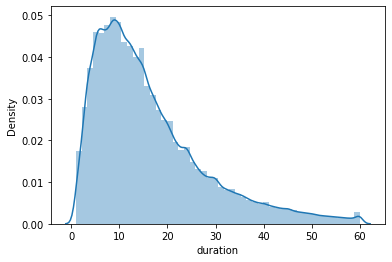

In [39]:
sns.distplot(new_df.duration)

How many records were dropped?

In [40]:
df.shape[0] - new_df.shape[0]

44286

A total of 44286 were dropped

### Q3. Missing values

In [41]:
#Selecting the needed features
categorical = ['PUlocationID', 'DOlocationID']
new_df[categorical] = new_df[categorical].fillna(-1)

C:\Users\Daniel Tomiwa\AppData\Local\Temp\ipykernel_9612\3520096891.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[categorical] = new_df[categorical].fillna(-1)


What is the fraction of missing values in the PUlocationID column?

In [42]:
(new_df['PUlocationID'] == -1).mean()

0.8352732770722617

we had 83% null values in the PUlocationID column

### Q4. One hot encoding

In [43]:
train_dicts = new_df[categorical].astype(str).to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

The number of columns in the feature matrix

In [44]:
X_train.shape[1]

525

There are 525 columns in the feature matrix

### Q5. Training a model

In [45]:
target = 'duration'
y_train = new_df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.52851910721103

The root mean squared error is 10.52 on the train dataset

### Q6. Evaluating the model

In [64]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
        df.dropOff_datetime = pd.to_datetime(df.dropOff_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PUlocationID', 'DOlocationID']
    new_df[categorical] = new_df[categorical].fillna(-1)
    df[categorical] = df[categorical].astype(str)
    
    return df

In [79]:
val_df = read_dataframe('data/fhv_tripdata_2021-02.parquet')
categorical = ['PUlocationID', 'DOlocationID']
val_dicts = val_df[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts)
y_val = val_df['duration']

In [82]:
y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.364434417438803

The root mean squared error on the val set is 11.36